# Clustering SQL Developers - Stack Overflow Survey 2016

Every year, Stack Overflow runs a survey asking developers about their work and the technologies they use. In the 2016 iteration, more than 50,000 developers completed the survey. I wasn't able to find any detailed analyses using the raw data ([http://stackoverflow.com/research](http://stackoverflow.com/research)), so I decided to play around with the dataset to see if there are any interesting patterns -- particularly relating to usage of SQL Server and other RDBMS. 

Let's define a **"SQL developer"** as a Stack Overflow 2016 Survey respondent who indicated they **'did extensive development work' in "SQL" or "SQL Server" in the past year.**

This notebook looks at three questions:

1. What does the SQL developer space look like?

2. Can SQL developers be clustered into distinct groups based on their reported characteristics? (region, age, occupation, experience, technologies, dev environment, desktop OS) 

3. Which characteristics are most associated with SQL Server?

4. What is SQL Server's "developer share" in various technologies?

I'm particularly curious to see how these statistics shift over the next few years, in light of the introduction of [SQL Server on Linux](https://www.microsoft.com/en-us/sql-server/sql-server-vnext-including-Linux). 

*CAVEAT: This analysis assumes that survey respondents understood 'SQL Server' to mean Microsoft's SQL Server, and 'SQL' to mean any other RDBMS. To the extent that respondents conflated these two terms, these numbers will be biased.*

## Data preparation

Of the 43,007 developers who reported the characteristics listed above, 21,675 (50.5%) are SQL developers. First, we'll convert the raw CSV file into a binary feature DataFrame using pandas.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import brewer2mpl

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Stack Overflow survey raw data
# Download here: http://stackoverflow.com/research
df = pd.read_csv('2016 Stack Overflow Survey Responses.csv')
print('Shape:', df.shape)

Shape: (56030, 66)


In [3]:
# Preview first couple of rows of raw data
df[:2]

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...


In [4]:
# Fill in job cells for students so we don't drop them as empty
df['company_size_range'] = df.apply(lambda row: 
                                    'student' if row['employment_status'] == 'I\'m a student' 
                                    else row['company_size_range'], axis=1)

# Fill in industry b/c a lot of people didn't specify
df['industry'] = df.apply(lambda row: 'Other industry' if pd.isnull(row['industry']) 
                           or row['industry'] == 'Other (please specify)'
                           else row['industry'], axis=1)

# Fill in tech_want cells to differentiate from tech_do
df['tech_want'] = df.apply(lambda row: 'nothing' if pd.isnull(row['tech_want']) 
                           else 'Want ' + '; Want'.join(row['tech_want'].split(';')), axis=1)

In [5]:
# Grab the features we'll use for clustering
clean_df = df[['un_subregion', 'age_range', 'occupation', 
               'experience_range', 'tech_do', 'tech_want', 'company_size_range', 
               'dev_environment', 'desktop_os', 'industry']]

# Drop respondents who left answers blank
clean_df = clean_df.dropna().reset_index().drop('index', 1)

# Create lists of related features
region_options = list(set(clean_df['un_subregion']))
age_range_options = list(set(clean_df['age_range']))
occupation_options = list(set(clean_df['occupation']))
experience_range_options = list(set(clean_df['experience_range']))
tech_options = list(set(';'.join(clean_df['tech_do']).replace('; ', ';').split(';')))
tech_want_options = list(set(';'.join(clean_df['tech_want']).replace('; ', ';').split(';')))
company_size_range_options = list(set(clean_df['company_size_range']))
dev_environment_options = list(set(';'.join(clean_df['dev_environment']).replace('; ', ';').split(';')))
desktop_os_options = list(set(clean_df['desktop_os']))
industry_options = list(set(clean_df['industry']))

# Overall feature set for clustering
key = region_options + age_range_options + occupation_options + \
    experience_range_options + tech_options + tech_want_options + company_size_range_options + \
    dev_environment_options + desktop_os_options + industry_options

# We're going to ignore tech_want and industry for clustering
# since they only seem to add noise
key_minus_want = [x for x in key if x not in tech_want_options and x not in industry_options]
key_minus_want = [x for x in key if x not in tech_want_options]

print('Cleaned shape:', clean_df.shape)

Cleaned shape: (43007, 10)


In [6]:
# Convert dataframe into a binary feature matrix
dataset = np.zeros([len(clean_df), len(key)])
for i, response in clean_df.iterrows():
    for k in ';'.join(response).replace('; ', ';').split(';'):
        dataset[i, key.index(k)] = 1
dataset = pd.DataFrame(dataset, columns=key)
print('Dataset shape:', dataset.shape)

Dataset shape: (43007, 214)


In [7]:
# Reduce dataset to only include SQL developers
total_devs = len(dataset)
dataset = dataset[dataset['SQL'] + dataset['SQL Server'] > 0]
dataset = dataset.reset_index().drop('index', 1).astype(int)
print('Total developers: {0}'.format(total_devs))
print('SQL developers: {0} ({1:.1f}%)'.format(len(dataset),
                                              100.0*len(dataset)/total_devs))

Total developers: 43007
SQL developers: 21675 (50.4%)


In [8]:
# Add columns indicating whether each dev is using SQL, SQL Server, or both
dataset['sql_only'] = dataset.apply(lambda row: max(0, row['SQL'] - row['SQL Server']), axis=1)
dataset['sqlserver_only'] = dataset.apply(lambda row: max(0, row['SQL Server'] - row['SQL']), axis=1)
dataset['both'] = dataset.apply(lambda row: row['SQL Server'] * row['SQL'], axis=1)

print('Overall developer share:')
print('------------------------')
print('sqlserver_only: {0:d} ({1:.1f}%)'.format(int(dataset['sqlserver_only'].sum()), 
                                                100*dataset['sqlserver_only'].mean()))
print('both: {0:d} ({1:.1f}%)'.format(int(dataset['both'].sum()), 
                                      100*dataset['both'].mean()))
print('sql_only: {0:d} ({1:.1f}%)'.format(int(dataset['sql_only'].sum()), 
                                          100*dataset['sql_only'].mean()))

Overall developer share:
------------------------
sqlserver_only: 2049 (9.5%)
both: 6357 (29.3%)
sql_only: 13269 (61.2%)


In [9]:
# Add a 'startup' column if company has under 20 employees 
# Obviously this is an imperfect definition, but let's go with it for now
dataset['startup'] = dataset.apply(lambda row: min(1, row['1-4 employees']
                                                   + row['5-9 employees']
                                                   + row['10-19 employees']), axis=1)

In [10]:
# Preview the dataset
dataset[:2]

,Western Africa,Central America,Southern Europe,Central Asia,Middle Africa,Western Europe,South-Eastern Asia,South America,Western Asia,Eastern Asia,...,Automotive,Consumer Products,Foundation / Non-Profit,Defense,Manufacturing,Retail,sql_only,sqlserver_only,both,startup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


## Can SQL developers be clustered into distinct groups?

Let's use k-means to cluster SQL developers based on the characteristics above. I picked k=10 clusters arbitrarily after trying a few different values, and finding that this value results in reasonable-looking clusters with distinctive characteristics. 

It's interesting to look at which clusters tend to over lap, versus those that are far apart. 

If we use [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) to reduce the dimensionality of our dataset, we can plot each SQL developer on a 2D graph and color by cluster. 

In [11]:
# Dataset is 150-dimensional, so reduce with PCA
# (makes k-means more tractable vs. curse of dimensionality)
pca = PCA(n_components=20).fit_transform(dataset[key_minus_want]) # wants don't add much

# Store the first 2 components so we can visualize in 2D space
dataset['pca0'] = pca[:,0]
dataset['pca1'] = pca[:,1]

In [12]:
# Assign each developer to a cluster using k-means (takes a few seconds)
# Seed random_state to make deterministic
n_clusters = 10 # arbitrary; seems to work well
est = KMeans(n_clusters=n_clusters, random_state=0)
est.fit(pca)
clusters = est.predict(pca)
dataset['cluster'] = clusters

In [13]:
# For each cluster, print the mean (centroid) characteristics shared by more than 50% of its members
threshold = 0.5
cluster_desc = []
for c in range(n_clusters):
    desc = ''
    cluster_members = dataset[dataset['cluster'] == c][key]
    print('Cluster {0} (n={1}):'.format(c, len(cluster_members)))
    print('-------------------')
    cluster_feature_means = cluster_members[key_minus_want].mean(axis=0)
    defining_features = cluster_feature_means[cluster_feature_means > threshold]
    for f in defining_features.index:
        print('{0:.2f} {1}'.format(defining_features[f], f))
        desc += f + ', '
    desc = desc[:-2]
    if c < n_clusters - 1:
        print('')
    cluster_desc.append(desc)

Cluster 0 (n=2909):
-------------------
0.99 11+ years
0.92 C#
0.68 JavaScript
0.78 SQL
0.82 SQL Server
0.98 Visual Studio
0.57 Notepad++

Cluster 1 (n=1405):
-------------------
0.68 C#
0.89 Java
0.88 Android
0.67 PHP
0.81 JavaScript
0.95 SQL
0.70 Android Studio
0.65 Visual Studio
0.54 Notepad++

Cluster 2 (n=1826):
-------------------
0.68 Full-stack web developer
0.71 Node.js
0.62 AngularJS
0.52 PHP
0.97 JavaScript
0.99 SQL
0.64 Sublime
0.78 Mac OS X

Cluster 3 (n=2263):
-------------------
0.93 Java
0.60 JavaScript
0.98 SQL
0.75 Eclipse
0.69 Notepad++

Cluster 4 (n=2706):
-------------------
0.57 Full-stack web developer
0.98 PHP
0.90 JavaScript
0.98 SQL

Cluster 5 (n=2024):
-------------------
0.98 6 - 10 years
0.94 C#
0.70 JavaScript
0.79 SQL
0.78 SQL Server
0.97 Visual Studio
0.63 Notepad++

Cluster 6 (n=2157):
-------------------
0.99 11+ years
0.54 Java
0.55 JavaScript
0.98 SQL

Cluster 7 (n=1864):
-------------------
0.58 20-24
0.71 Student
0.70 Java
0.55 PHP
0.60 JavaScript


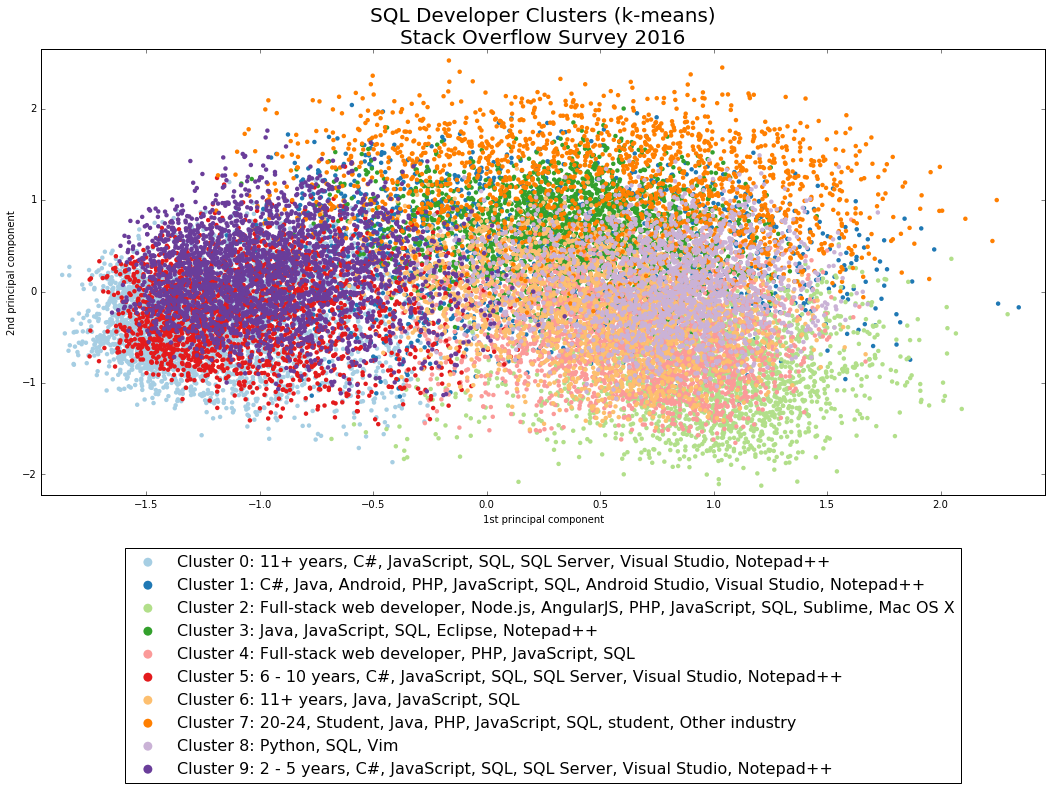

In [14]:
# Scatter plot the first 2 principal components, colored by cluster type
plt.figure(figsize=[18, 8])
plt.title('SQL Developer Clusters (k-means)\nStack Overflow Survey 2016', fontsize=20)
color_list = np.array(brewer2mpl.COLOR_MAPS['Qualitative']['Paired']['10']['Colors']) / 255
for i in range(n_clusters):
    subset = dataset[dataset['cluster'] == i]
    plt.scatter(subset['pca0'], subset['pca1'], label='Cluster {0}: {1}'.format(i, cluster_desc[i]),
                s=20, c=color_list[i], edgecolor='none')

plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')
margin = 1.05
plt.xlim(margin * pca[:,0].min(), margin * pca[:,0].max())
plt.ylim(margin * pca[:,1].min(), margin * pca[:,1].max())

plt.legend(markerscale=2, fontsize=16, scatterpoints=1, loc=9, bbox_to_anchor=(0.5, -0.1))
plt.show()

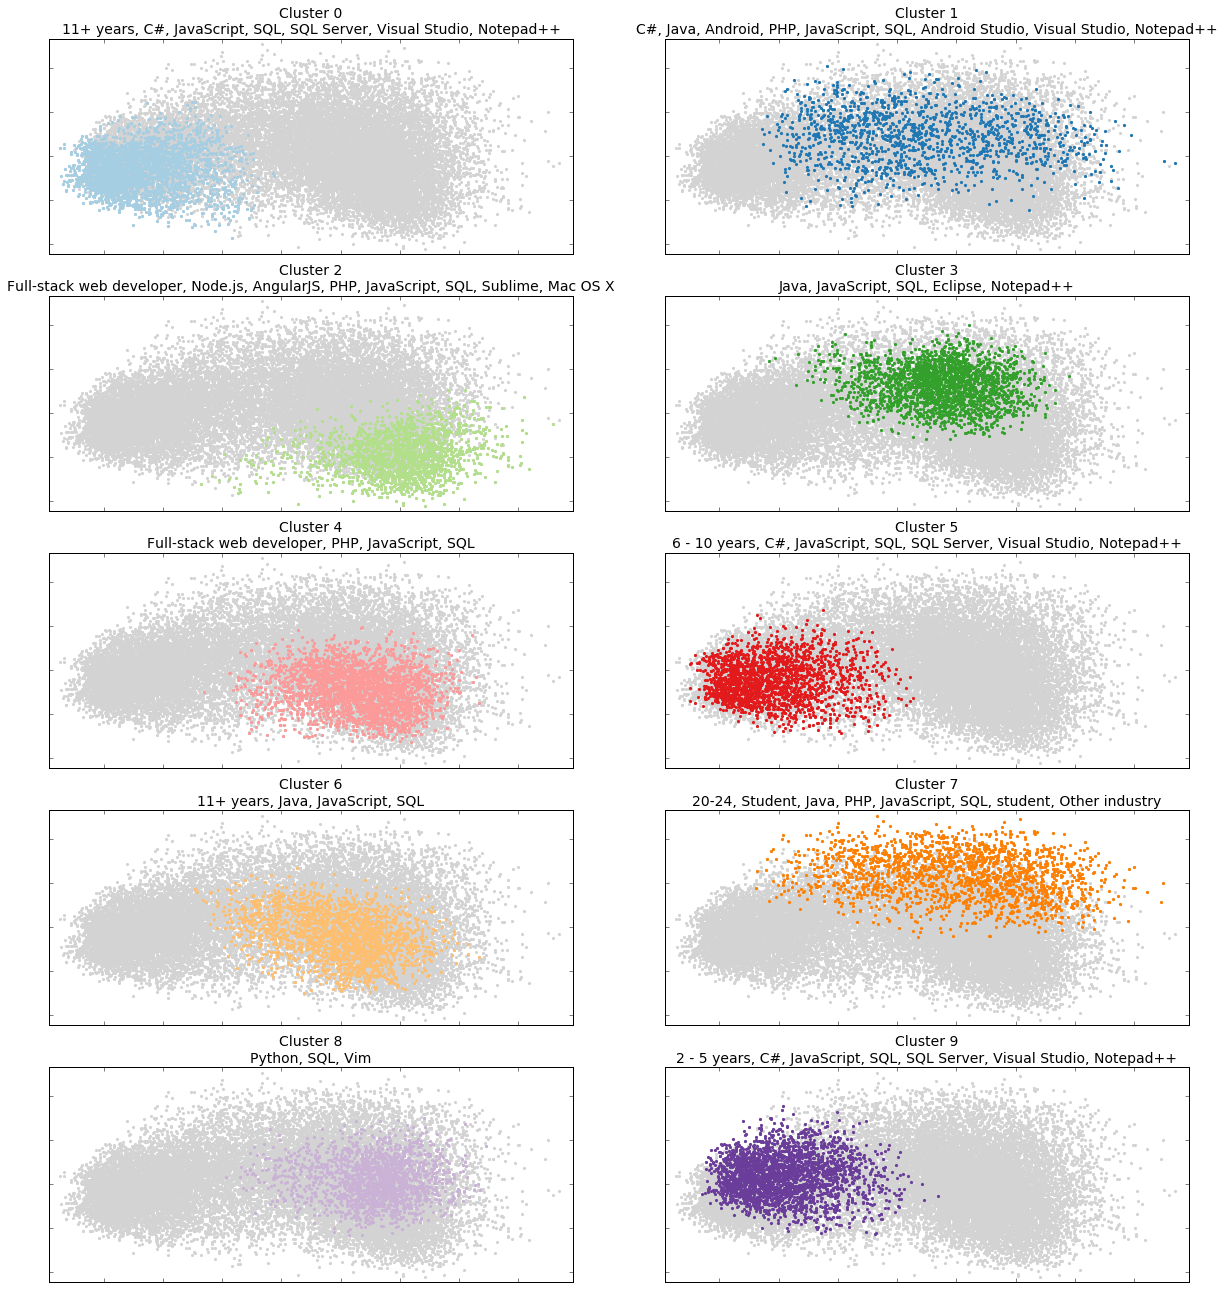

In [15]:
# Same thing, but each cluster on a separate plot to make it easier to see
plt.figure(figsize=[18, 18])
n_rows = 5
n_cols = 2
color_list = np.array(brewer2mpl.COLOR_MAPS['Qualitative']['Paired']['10']['Colors']) / 255

for i in range(n_clusters):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title('Cluster {0}\n{1}'.format(i, cluster_desc[i]), fontsize=14)
    plt.scatter(dataset['pca0'], dataset['pca1'], s=10, alpha=1, c='lightgray', linewidths=0)
    plt.scatter(dataset[dataset['cluster'] == i]['pca0'], 
                dataset[dataset['cluster'] == i]['pca1'], 
                s=10, alpha=1, c=color_list[i], linewidths=0)
    margin = 1.05
    plt.xlim(margin * pca[:,0].min(), margin * pca[:,0].max())
    plt.ylim(margin * pca[:,1].min(), margin * pca[:,1].max())
    plt.tick_params(labelbottom='off', labelleft='off')
plt.tight_layout()
plt.show()

## Which types of developers use RDBMS?

There's a clear visual separation between SQL developers who use SQL Server vs. those who use another RDBMS. Comparing with the cluster segmentations above, SQL Server developers heavily overlap with the C#, JavaScript, Visual Studio, and Notepad++ clusters, and are particularly distant from the iOS, Node.js, Sublime, Mac OS X, and student clusters.   

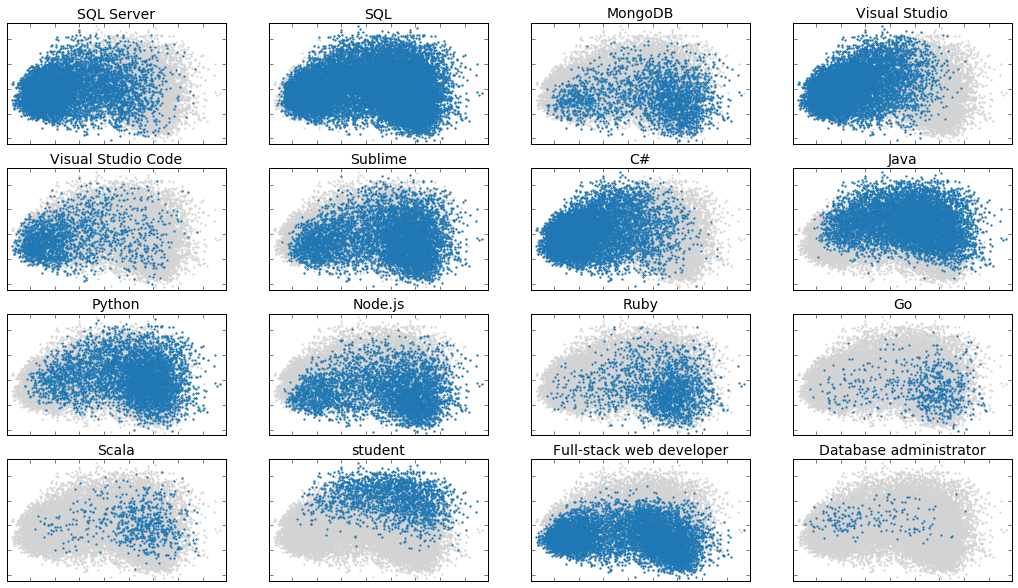

In [17]:
# Plot same cluster cloud, and highlight developers who use SQL Server or other technologies
techs = ['SQL Server', 'SQL', 'MongoDB',
         'Visual Studio', 'Visual Studio Code', 'Sublime',
         'C#', 'Java', 'Python', 'Node.js', 'Ruby', 'Go', 'Scala',
         'student', 'Full-stack web developer', 'Database administrator'] # 
plt.figure(figsize=[18, 10])
n_rows = 4
n_cols = 4
color_list = np.array(brewer2mpl.COLOR_MAPS['Qualitative']['Paired']['10']['Colors']) / 255

for i, tech in enumerate(techs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(tech, fontsize=14)
    plt.scatter(dataset['pca0'], dataset['pca1'], 
                s=5, alpha=1, c='lightgray', linewidths=0)
    plt.scatter(dataset[dataset[tech] == 1]['pca0'], 
                dataset[dataset[tech] == 1]['pca1'], 
                s=5, alpha=1, c=color_list[1], linewidths=0)
    margin = 1.05
    plt.xlim(margin * pca[:,0].min(), margin * pca[:,0].max())
    plt.ylim(margin * pca[:,1].min(), margin * pca[:,1].max())
    plt.tick_params(labelbottom='off', labelleft='off')

plt.show()

## Which types of developers use SQL Server?
More than 70% of Stack Overflow developers who use SQL Server also use:
* Visual Studio (80%)
* C# (78%)
* JavaScript (72%)

In [18]:
# Co-occurrence matrix
# Dot product tells us how many times each feature co-occurs with each other feature
coocc = np.dot(dataset.T, dataset)
diagonal = np.diagonal(coocc)
with np.errstate(divide='ignore', invalid='ignore'):
    coocc_pct = np.nan_to_num(np.true_divide(coocc, diagonal[:, None]))
coocc_pct = pd.DataFrame(coocc_pct)
coocc_pct.columns = dataset.columns
coocc_pct.index = dataset.columns
coocc_pct.insert(0, 'n', diagonal)

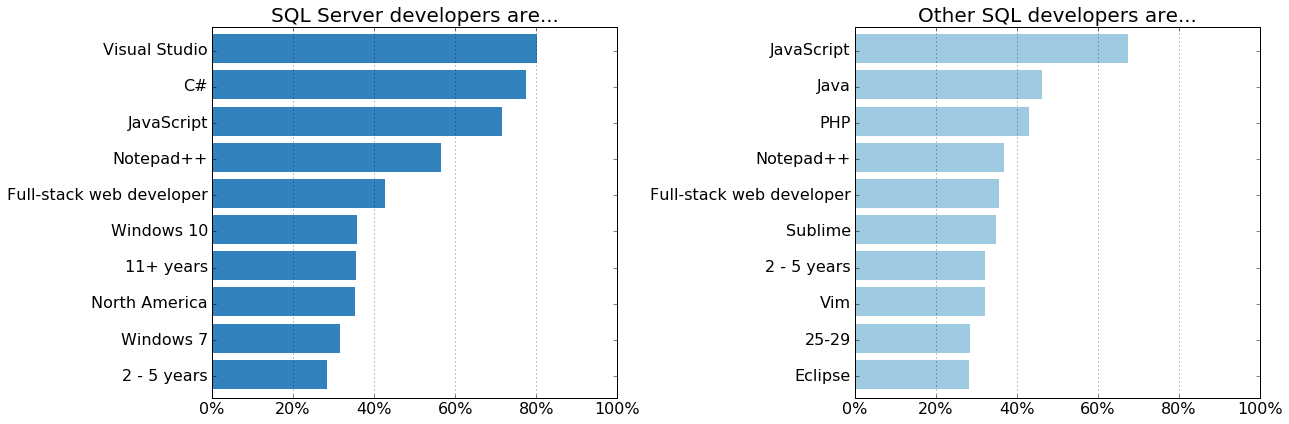

In [19]:
# What characteristics co-occur most often with SQL Server?
ignore = ['n', 'both', 'pca0', 'pca1', 'cluster', 'SQL', 'SQL Server', 'sql_only'] + tech_want_options
most_common_sqlserver = coocc_pct.ix['SQL Server'][~coocc_pct.ix['SQL Server'].index.isin(ignore)]
most_common_sqlserver.order(ascending=False, inplace=True)
most_common_sqlserver = most_common_sqlserver[:10]
most_common_sqlserver.sort()

most_common_sql = coocc_pct.ix['sql_only'][~coocc_pct.ix['sql_only'].index.isin(ignore)]
most_common_sql.order(ascending=False, inplace=True)
most_common_sql = most_common_sql[:10]
most_common_sql.sort()

plt.figure(figsize=[18, 6])
n_rows = 1
n_cols = 2
color_list = np.array(brewer2mpl.COLOR_MAPS['Sequential']['Blues']['3']['Colors']) / 255
xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]

ys = np.array(range(len(most_common_sqlserver)))
ax = plt.subplot(n_rows, n_cols, 1)
plt.title('SQL Server developers are...', fontsize=20)
plt.barh(ys, most_common_sqlserver, height=0.8, color=color_list[2], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_sqlserver.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_sqlserver))
ax.set_xlim(0, 1)
plt.grid(axis='x')

ys = np.array(range(len(most_common_sql)))
ax = plt.subplot(n_rows, n_cols, 2)
plt.title('Other SQL developers are...', fontsize=20)
plt.barh(ys, most_common_sql, height=0.8, color=color_list[1], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_sql.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_sql))
ax.set_xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.show()

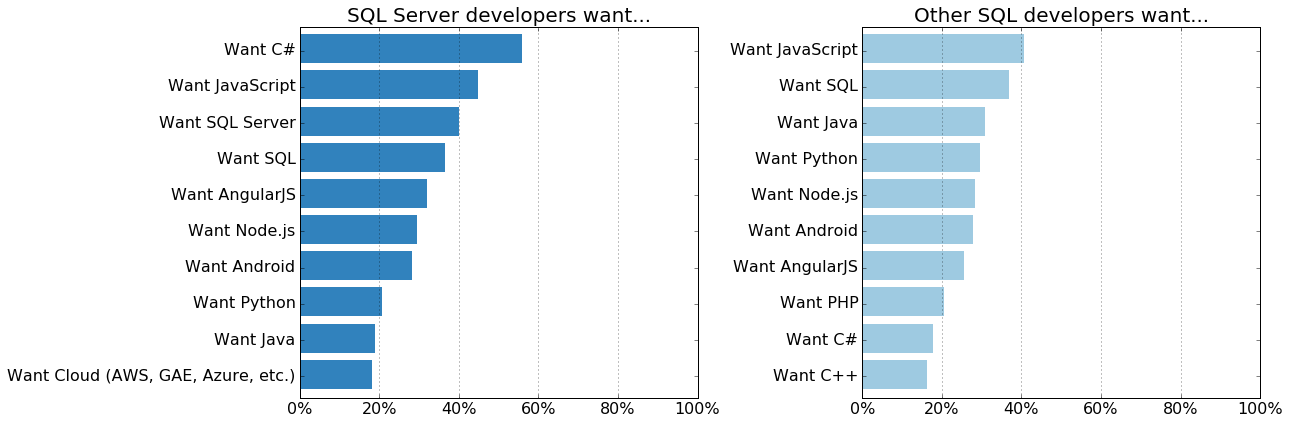

In [20]:
# What do SQL Server and non-SQL Server developers want?
ignore = ['n', 'both', 'pca0', 'pca1', 'cluster', 'SQL', 'SQL Server', 'sql_only']
most_common_sqlserver = coocc_pct.ix['SQL Server'][tech_want_options]
most_common_sqlserver.order(ascending=False, inplace=True)
most_common_sqlserver = most_common_sqlserver[:10]
most_common_sqlserver.sort()

most_common_sql = coocc_pct.ix['sql_only'][tech_want_options]
most_common_sql.order(ascending=False, inplace=True)
most_common_sql = most_common_sql[:10]
most_common_sql.sort()

plt.figure(figsize=[18, 6])
n_rows = 1
n_cols = 2
color_list = np.array(brewer2mpl.COLOR_MAPS['Sequential']['Blues']['3']['Colors']) / 255
xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]

ys = np.array(range(len(most_common_sqlserver)))
ax = plt.subplot(n_rows, n_cols, 1)
plt.title('SQL Server developers want...', fontsize=20)
plt.barh(ys, most_common_sqlserver, height=0.8, color=color_list[2], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_sqlserver.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_sqlserver))
ax.set_xlim(0, 1)
plt.grid(axis='x')

ys = np.array(range(len(most_common_sql)))
ax = plt.subplot(n_rows, n_cols, 2)
plt.title('Other SQL developers want...', fontsize=20)
plt.barh(ys, most_common_sql, height=0.8, color=color_list[1], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_sql.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_sql))
ax.set_xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.show()

## What is SQL Server's "developer share"?

Overall, a little over a third of SQL developers use SQL Server.

In this snapshot, SQL Server has the strongest developer share (>50%) among developers who use SharePoint, F#, Visual Basic, C#, and Salesforce. In terms of occupations, it has the strongest presence in traditional roles: DBAs, BI & data warehousing, desktop software, and enterprise developers. Most SQL developers who use Visual Studio or Visual Studio Code use SQL Server, whereas most SQL developers who use Sublime or Eclipse do not. 

As a related interesting note, 95% of SQL developers use at least one of the following: C#, Java, PHP, Python, or Node.js.

In [21]:
def plot_sql_developer_share(attrs, group_name, sort_by_sqlserver=True, figsize=(18, 16)):
    '''
    Plots a stacked horizontal bar chart, showing sqlserver_only vs. both vs. sql_only
    for a given set of attributes.
    '''
    sql_only = []
    sqlserver_only = []
    both = []
    ns = []
    for attr in attrs:
        sql_only.append(dataset[dataset[attr] == 1]['sql_only'].mean())
        sqlserver_only.append(dataset[dataset[attr] == 1]['sqlserver_only'].mean())
        both.append(dataset[dataset[attr] == 1]['both'].mean())
        ns.append(len(dataset[dataset[attr] == 1]))

    if sort_by_sqlserver:
        zipped = zip(sql_only, both, sqlserver_only, ns, attrs)
        x = list(zipped)
        x.sort(reverse=True)
        sql_only, both, sqlserver_only, ns, attrs = list(zip(*x))

    ys = np.array(range(len(attrs)))
    xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]
    color_list = np.array(brewer2mpl.COLOR_MAPS['Sequential']['Blues']['3']['Colors']) / 255

    alpha = 0.75
    fig, ax = plt.subplots(figsize=figsize)
    plt.title('SQL Server\'s "developer share" by {0}'.format(group_name), fontsize=20)
    plt.barh(ys, sqlserver_only, height=0.8, 
             color=color_list[2], alpha=alpha, linewidth=0, label='SQL Server only')
    plt.barh(ys, both, height=0.8, left=sqlserver_only,
             color=color_list[1], alpha=alpha, linewidth=0, label='SQL Server + other RDBMS')
    plt.barh(ys, sql_only, height=0.8, left=np.array(sqlserver_only)+np.array(both),
             color=color_list[0], alpha=alpha, linewidth=0, label='Other RDBMS only')

    ax.set_yticks(ys+0.35)
    ax.set_yticklabels(attrs, fontsize=16)
    ax.set_xticklabels(xs, fontsize=16)
    ax.set_ylim(-0.25, len(attrs))
    ax.set_xlim(0, 1)

    plt.legend(loc='bottom right', frameon=1, fontsize=16)
    plt.grid(axis='x')

    ax2 = ax.twinx()
    ax2.set_yticks(ys+0.35)
    ax2.set_yticklabels(ns, fontsize=16)
    ax2.set_ylim(-0.25, len(attrs))

    plt.show()

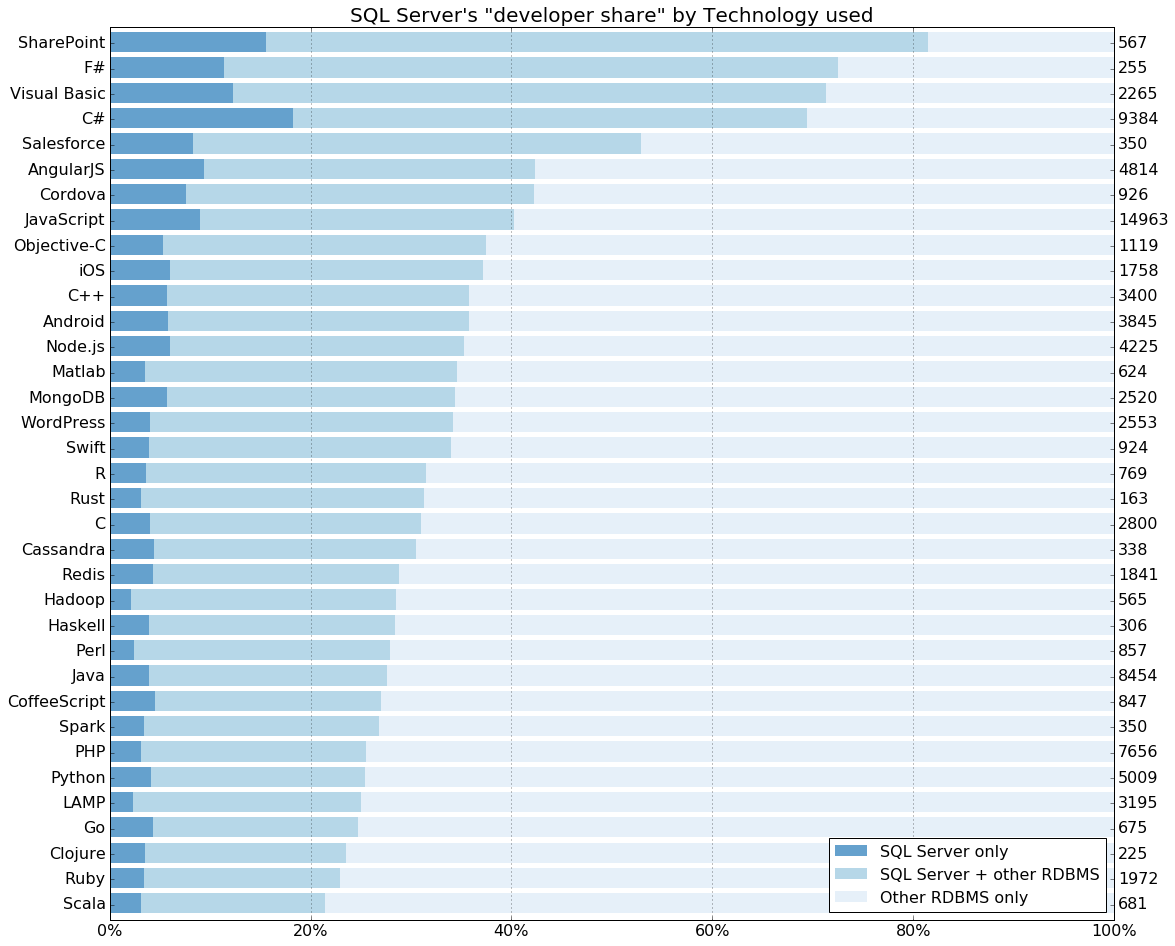

In [22]:
techs = ['Android', 'AngularJS', 'C', 'C#', 'C++', 'Cassandra', 
         'Clojure', 'CoffeeScript', 'Cordova', 'F#', 'Go', 'Hadoop', 
         'Haskell', 'iOS', 'Java', 'JavaScript', 'LAMP', 'Matlab', 
         'MongoDB', 'Node.js', 'Objective-C', 'Perl', 'PHP', 'Python', 
         'R', 'Redis', 'Ruby', 'Rust', 'Salesforce', 'Scala', 'SharePoint', 
         'Spark', 'Swift', 'Visual Basic', 'WordPress']
plot_sql_developer_share(techs, 'Technology used')

In [23]:
# Related question: Which technologies are most commonly used by SQL developers?
tech_frequency = dataset[techs].mean().sort(inplace=False, ascending=False)
tech_frequency

JavaScript      0.690334
C#              0.432941
Java            0.390035
PHP             0.353218
Python          0.231096
AngularJS       0.222099
Node.js         0.194925
Android         0.177393
C++             0.156863
LAMP            0.147405
C               0.129181
WordPress       0.117785
MongoDB         0.116263
Visual Basic    0.104498
Ruby            0.090980
Redis           0.084937
iOS             0.081107
Objective-C     0.051626
Cordova         0.042722
Swift           0.042630
Perl            0.039539
CoffeeScript    0.039077
R               0.035479
Scala           0.031419
Go              0.031142
Matlab          0.028789
SharePoint      0.026159
Hadoop          0.026067
Salesforce      0.016148
Spark           0.016148
Cassandra       0.015594
Haskell         0.014118
F#              0.011765
Clojure         0.010381
Rust            0.007520
dtype: float64

In [24]:
# What % of developers don't use ANY of the following:
# C#, Java, PHP, Python, Node.js
(dataset[['C#', 'Java', 'PHP', 'Python', 'Node.js']].sum(axis=1) == 0).mean()

0.05591695501730104

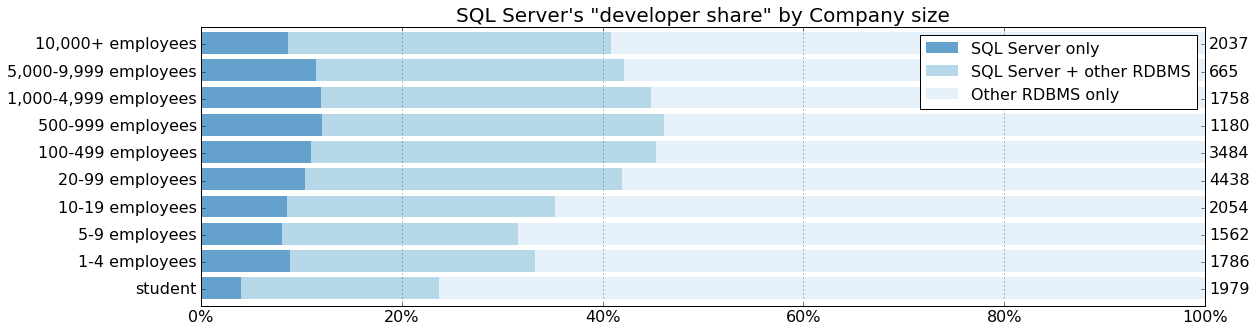

In [25]:
company_sizes = [
    'student',
    '1-4 employees',
    '5-9 employees',
    '10-19 employees',
    '20-99 employees',
    '100-499 employees',
    '500-999 employees',
    '1,000-4,999 employees',
    '5,000-9,999 employees',
    '10,000+ employees'
]
plot_sql_developer_share(company_sizes, 'Company size', sort_by_sqlserver=False, figsize=(18, 5))

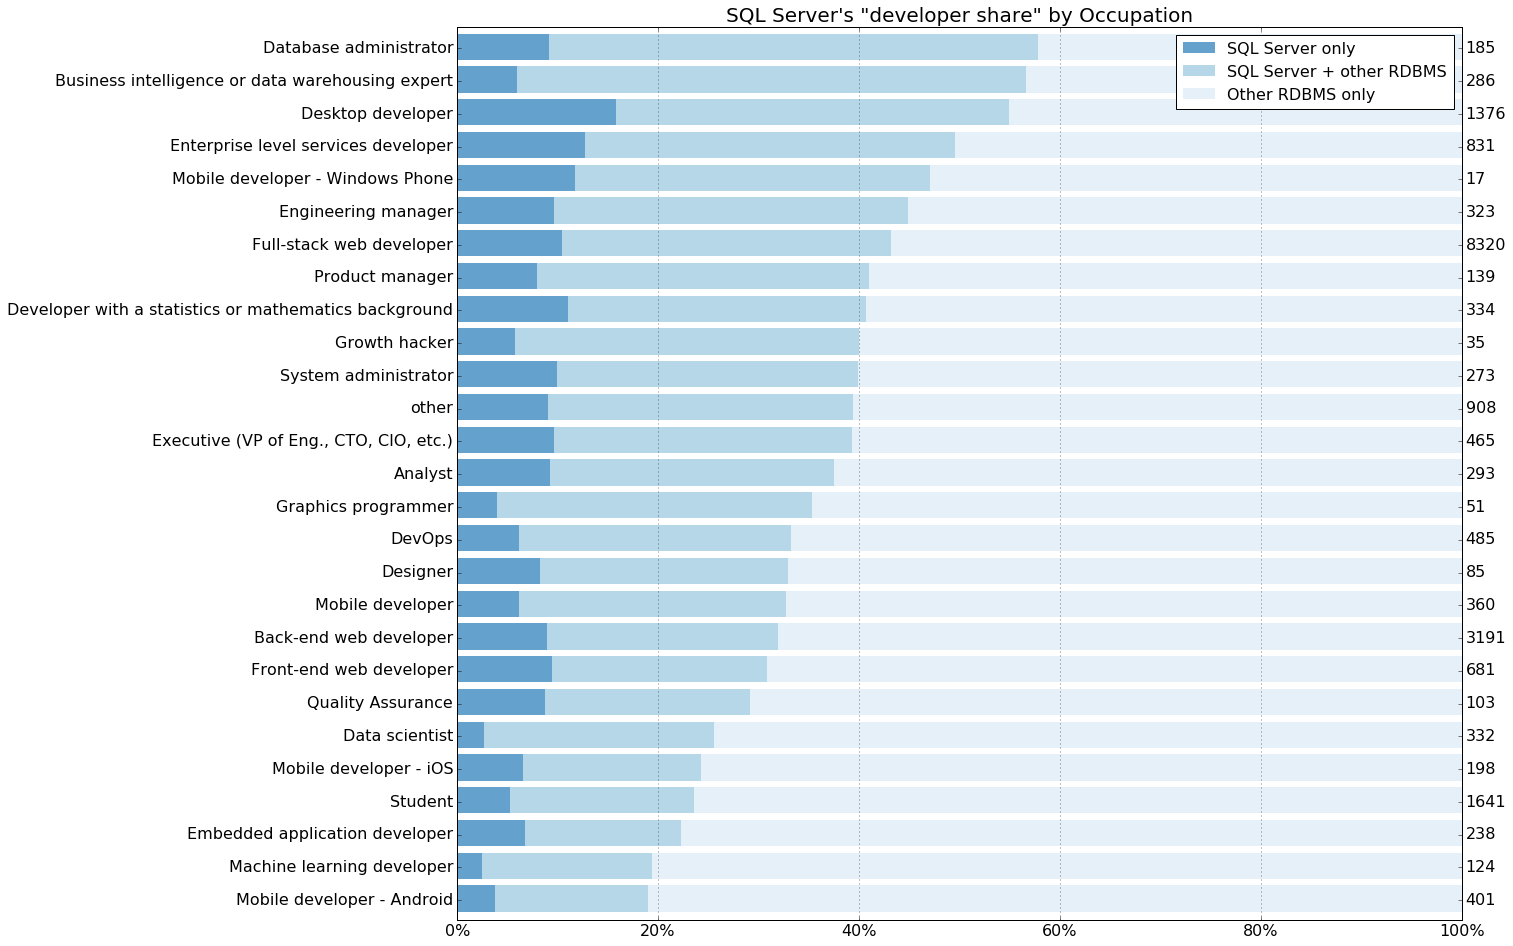

In [26]:
plot_sql_developer_share(occupation_options, 'Occupation', figsize=(18, 16))

In [36]:
# Do 'Machine learning developer' and 'Data scientist' SQL devs use Python or R?
print('Data scientists using an RDBMS:')
print(dataset[dataset['Data scientist'] == 1][['R', 'Python']].mean())
print('\nMachine learning developers using an RDBMS:')
print(dataset[dataset['Machine learning developer'] == 1][['R', 'Python']].mean())
print('\nDev with math background using an RDBMS:')
print(dataset[dataset['Developer with a statistics or mathematics background'] == 1][['R', 'Python']].mean())
print('\nBI/DW expert using an RDBMS:')
print(dataset[dataset['Business intelligence or data warehousing expert'] == 1][['R', 'Python']].mean())

Data scientists using an RDBMS:
R         0.512048
Python    0.659639
dtype: float64

Machine learning developers using an RDBMS:
R         0.290323
Python    0.693548
dtype: float64

Dev with math background using an RDBMS:
R         0.203593
Python    0.377246
dtype: float64

BI/DW expert using an RDBMS:
R         0.104895
Python    0.307692
dtype: float64


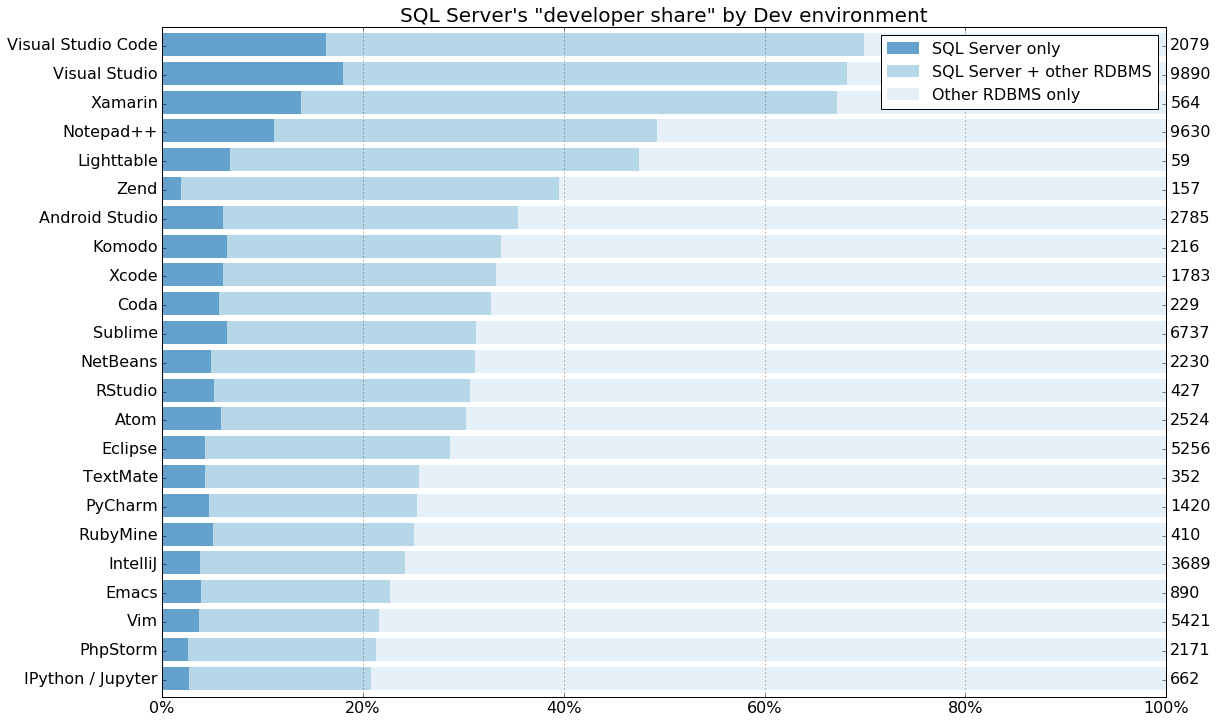

In [156]:
plot_sql_developer_share(dev_environment_options, 'Dev environment', figsize=(18, 12))

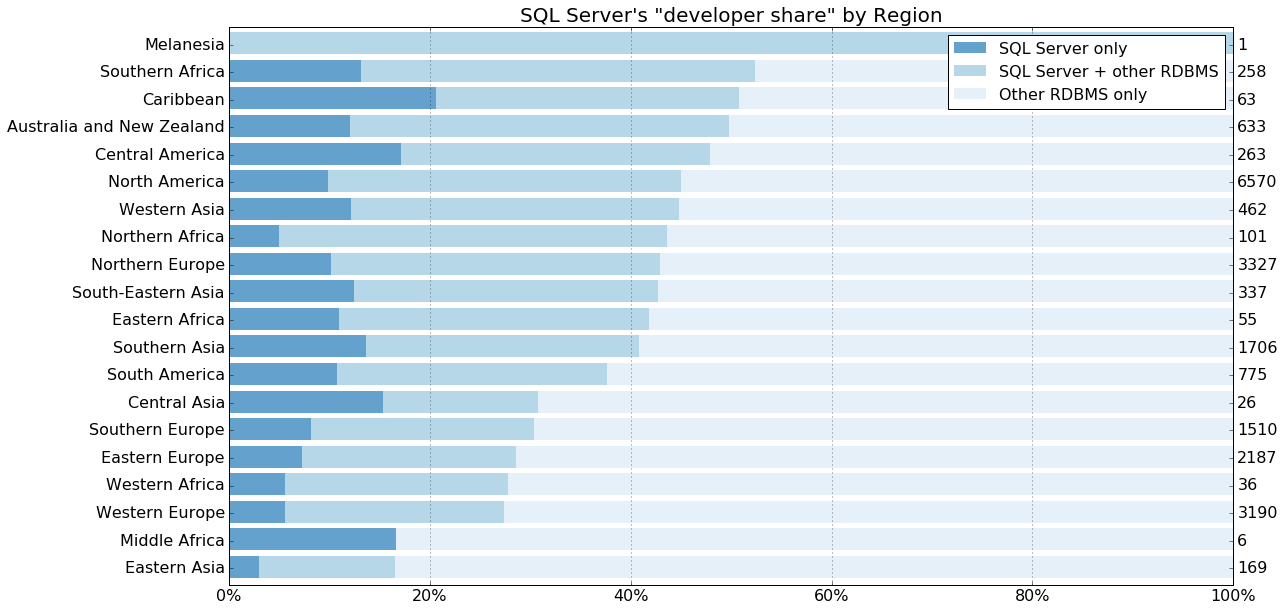

In [157]:
plot_sql_developer_share(region_options, 'Region', figsize=(18, 10))

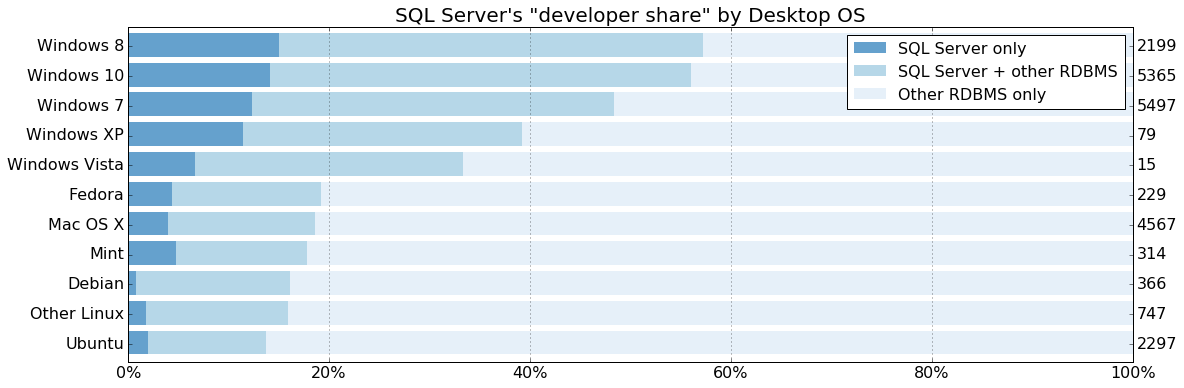

In [158]:
plot_sql_developer_share(desktop_os_options, 'Desktop OS', figsize=(18, 6))

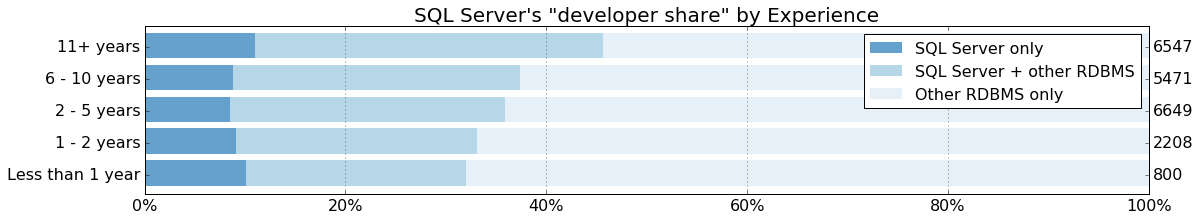

In [159]:
plot_sql_developer_share(experience_range_options, 'Experience', figsize=(18, 3))

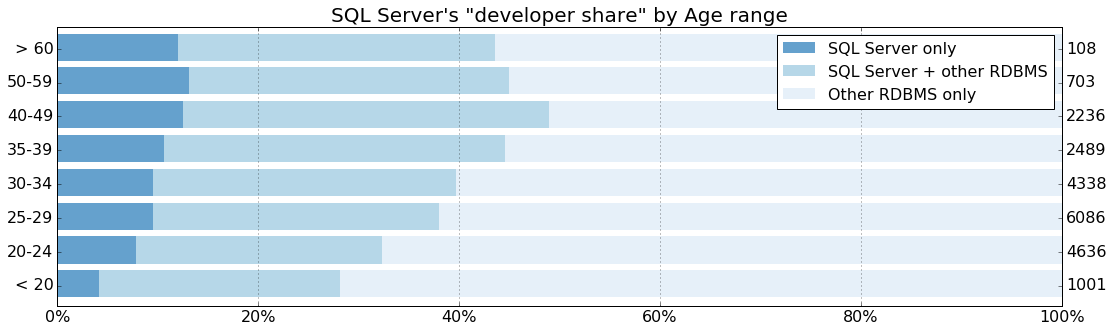

In [160]:
age_ranges = [
    '< 20',
    '20-24',
    '25-29',
    '30-34',
    '35-39',
    '40-49',
    '50-59',
    '> 60'
]
plot_sql_developer_share(age_ranges, 'Age range', sort_by_sqlserver=False, figsize=(18, 5))

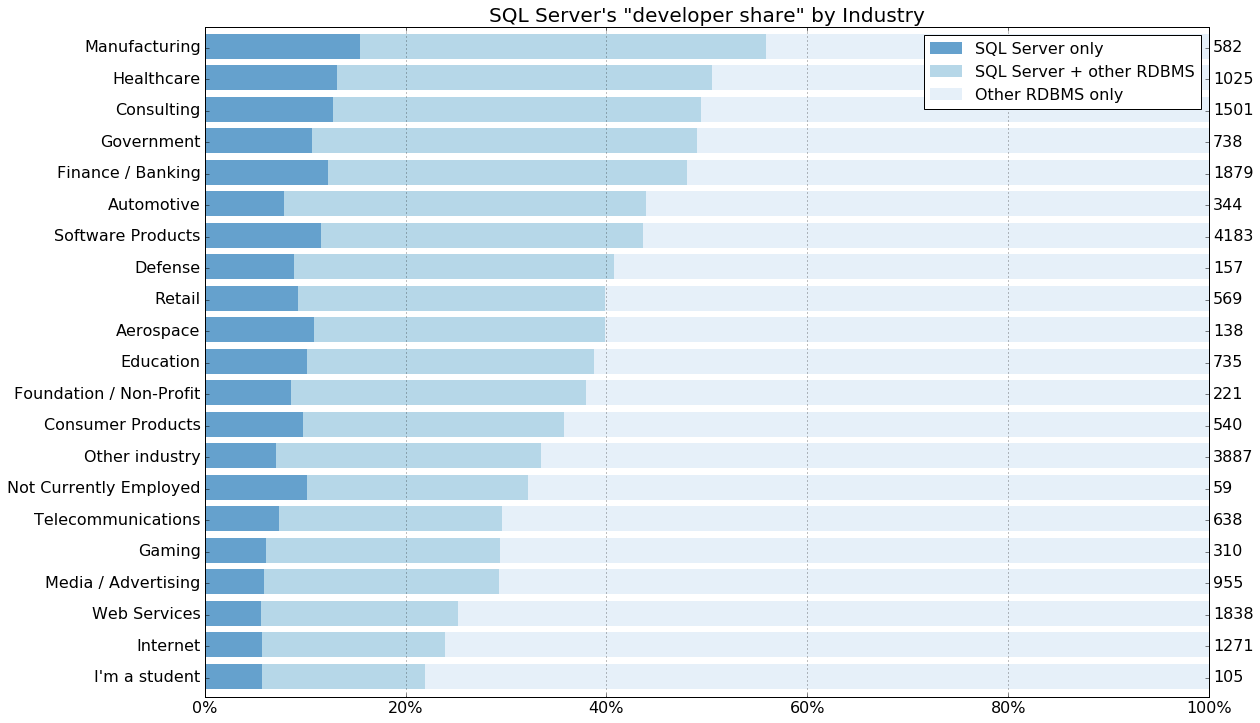

In [161]:
plot_sql_developer_share(industry_options, 'Industry', figsize=(18, 12))

## What do student and startup SQL developers use?

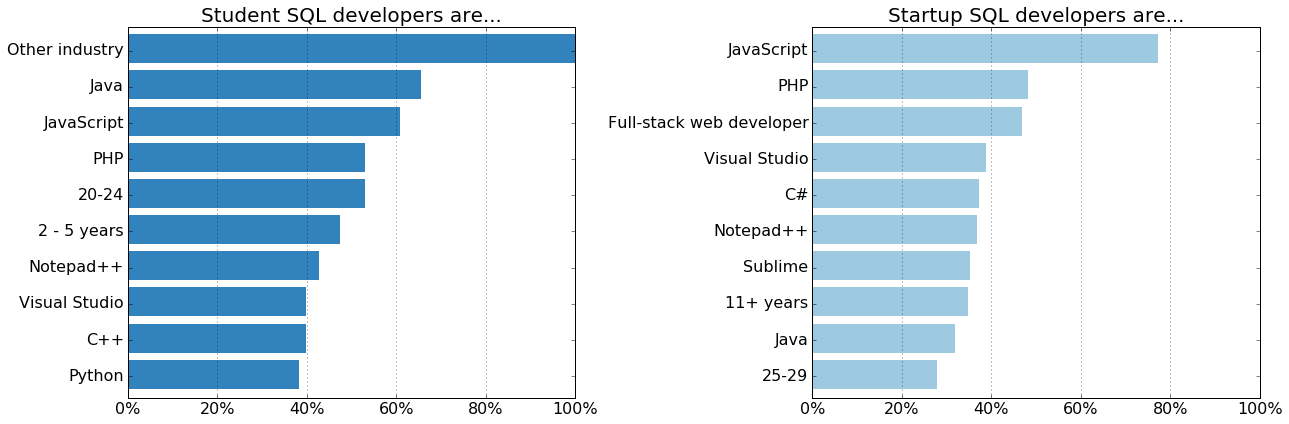

In [162]:
# What characteristics are most common in students and startups?
ignore = ['n', 'both', 'pca0', 'pca1', 'sql_only', 'SQL', 'SQL Server',
          'cluster', 'student', 'Student', 'startup'] + tech_want_options + company_size_range_options
most_common_student = coocc_pct.ix['student'][~coocc_pct.ix['student'].index.isin(ignore)]
most_common_student.order(ascending=False, inplace=True)
most_common_student = most_common_student[:10]
most_common_student.sort()

most_common_startup = coocc_pct.ix['startup'][~coocc_pct.ix['startup'].index.isin(ignore)]
most_common_startup.order(ascending=False, inplace=True)
most_common_startup = most_common_startup[:10]
most_common_startup.sort()

plt.figure(figsize=[18, 6])
n_rows = 1
n_cols = 2
color_list = np.array(brewer2mpl.COLOR_MAPS['Sequential']['Blues']['3']['Colors']) / 255
xs = ['{0}%'.format(x) for x in (100*np.linspace(0, 1, 6)).astype(int)]

ys = np.array(range(len(most_common_student)))
ax = plt.subplot(n_rows, n_cols, 1)
plt.title('Student SQL developers are...', fontsize=20)
plt.barh(ys, most_common_student, height=0.8, color=color_list[2], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_student.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_student))
ax.set_xlim(0, 1)
plt.grid(axis='x')

ys = np.array(range(len(most_common_startup)))
ax = plt.subplot(n_rows, n_cols, 2)
plt.title('Startup SQL developers are...', fontsize=20)
plt.barh(ys, most_common_startup, height=0.8, color=color_list[1], linewidth=0)
ax.set_yticks(ys+0.35)
ax.set_yticklabels(most_common_startup.index, fontsize=16)
ax.set_xticklabels(xs, fontsize=16)
ax.set_ylim(-0.25, len(most_common_startup))
ax.set_xlim(0, 1)
plt.grid(axis='x')

plt.tight_layout()
plt.show()